# Install libraries and load data

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np

In [2]:
ds = pd.read_csv("train.csv")
#ds.head()
ds = ds.head(10000)

In [3]:
#gets first row that particular column

ds.iloc[1]['comment_text']

"D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)"

In [4]:
ds[ds.columns[2:]].iloc[3111]

toxic            1
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
Name: 3111, dtype: int64

In [5]:
#!pip list

# display a list of installed packages in your Python environment along with their versions

# Preprocess

In [6]:
from tensorflow.keras.layers import TextVectorization

In [7]:
x = ds['comment_text']

# ds.columns[] returns all the column names

# ds[ds.columns[2:]] selects all the columns from the third one onwards

# .values converts the selected DataFrame slice into a NumPy array

y = ds[ds.columns[2:]].values
y

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=int64)

In [8]:
# number of words in the vocab
MAX_FEATURES = 200000

In [9]:
# Conv of text into num
vectorizer = TextVectorization(
                               # maximum number of unique tokens (words or characters) that the vectorizer will keep
                               max_tokens = MAX_FEATURES,
                               
                               # This sets the length of the output sequences.
                               # Each text input will be converted into a sequence of integers, and all sequences will
                               # be padded or truncated to this length of 1800 tokens
                               output_sequence_length = 1800,
                               
                               # Output of the TextVectorization layer will be sequences of integers.
                               # Each word in the input text will be mapped to an integer index based on the learned vocabulary
                               output_mode = 'int')


In [10]:
# x.values converts the DataFrame or Series into a NumPy array

# adapt tokenizes voc and counting the frequency of each token.
# It then builds a vocabulary that maps the most frequent tokens to unique integer indices

vectorizer.adapt(x.values)

In [11]:
# convert the text data in x.values into sequences of integers using the TextVectorization layer

vectorized_text = vectorizer(x.values)
vectorized_text

<tf.Tensor: shape=(10000, 1800), dtype=int64, numpy=
array([[  625,    75,     2, ...,     0,     0,     0],
       [36510,    53,  2122, ...,     0,     0,     0],
       [  485,   450,    69, ...,     0,     0,     0],
       ...,
       [    8,    19,   424, ...,     0,     0,     0],
       [  339,  4621,     8, ...,     0,     0,     0],
       [   44,    33,  2784, ...,     0,     0,     0]], dtype=int64)>

In [12]:

# Creates a TensorFlow dataset from vectorized_text (the input features) and y
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))

# Caches the dataset in memory to speed up access during training, especially in repeated epochs
dataset = dataset.cache()

# Randomly shuffles the dataset to ensure the model doesn't learn any patterns from the order of the data
dataset = dataset.shuffle(160000)

# Batches the dataset into smaller groups of 16 samples each, enabling efficient processing and training.
dataset = dataset.batch(16)

# Prefetches the next 8 batches while the current batch is being processed, reducing latency and improving training speed
dataset = dataset.prefetch(8)

In [13]:
# This line takes the first 70% of the dataset for training.
train = dataset.take(int(len(dataset)*.7))

# skips the first 70% of the dataset and takes the next 20% for validation.
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))

# skips the first 90% of the dataset and takes the final 10% for testing
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

# Creating Sequential Model

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [15]:

# Initializes a sequential model, which allows you to stack layers in a linear fashion.
model = Sequential()

# Create the embedding layer 
# Converts input text (which has been tokenized into integer sequences) into dense vectors of fixed size.
model.add(Embedding(MAX_FEATURES+1, 32))

# Adds a Bidirectional LSTM layer, which processes the sequence of words in both forward and backward directions.
# The LSTM layer with 32 units
model.add(Bidirectional(LSTM(32, activation='tanh')))

# Feature extractor Fully connected layers
# Act as feature extractors, transforming the output from the LSTM into a form suitable for the final classification task
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))

# The Final layer that outputs the prediction.
# The output layer with 6 units, corresponding to the number of classes or labels in your classification task.
model.add(Dense(6, activation='sigmoid'))

In [16]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')


In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [18]:
"""
Forward Pass
Loss Calculation
Backward Pass
Validation
"""    
# Model Training
# History object returned by model.fit() stores the training process's details

history = model.fit(train, epochs = 1, validation_data = val)

437/437 ━━━━━━━━━━━━━━━━━━━━ 599s 1s/step - loss: 0.1880 - val_loss: 0.0722


<Figure size 800x500 with 0 Axes>

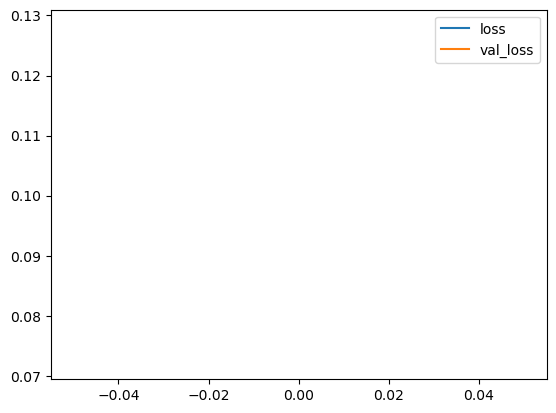

{'loss': [0.12816782295703888], 'val_loss': [0.0722305178642273]}


In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize = (8, 5))

# history.history contains the training and validation metrics (e.g., loss, accuracy) collected during each epoch.
# This dictionary is converted into a Pandas DataFrame for easier plotting.
# plot() is a Pandas method that creates a line plot for each metric.

pd.DataFrame(history.history).plot()
plt.legend()
plt.show()
print(history.history)

# Making Predictions

In [20]:
"""
input_text = vectorizer('You freaking suck! I am going to hit you.')
res = model.predict(input_text)
res
"""

"\ninput_text = vectorizer('You freaking suck! I am going to hit you.')\nres = model.predict(input_text)\nres\n"

In [21]:
# Convert input text to a tensor
input_text = tf.convert_to_tensor(vectorizer('You freaking suck! I am going to hit you.'))

"""
Add batch dimension (1, 1800)

The tf.expand_dims(input_text, 0) operation adds a new dimension at the 0th index, transforming the shape from
(1800,) to (1, 1800)
"""
input_text = tf.expand_dims(input_text, 0)

# Make prediction
# The model predicts the class probabilities for the input text

res = model.predict(input_text)
print(res)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[[0.8521514  0.3347564  0.72821057 0.03889926 0.74811876 0.11413777]]


In [22]:
"""
res > 0.5: This creates a boolean array where each element is True if the corresponding probability is greater than 0.5
and False otherwise.
astype(int): converts the boolean array into an integer array
"""
(res > 0.5).astype(int)


array([[1, 0, 1, 0, 1, 0]])

In [23]:
# To extract a single batch of data from the test dataset

# The .next() method retrieves the next batch of data from the iterator
# X and Y are features and corresponding labels
batch_X, batch_y = test.as_numpy_iterator().next()

print(f"\nBatch X\n{batch_X}")
print(f"\nBatch y\n{batch_y}")


Batch X
[[144 431  34 ...   0   0   0]
 [463 105  23 ...   0   0   0]
 [ 11  29 312 ...   0   0   0]
 ...
 [  2 193   4 ...   0   0   0]
 [133 441 308 ...   0   0   0]
 [ 40 438   4 ...   0   0   0]]

Batch y
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 0 1 0 1 0]]


In [24]:
(model.predict(batch_X) > 0.5).astype(int)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [25]:
# To check the shape of the output predictions from your model
res.shape

(1, 6)

# Model Evaluation

In [26]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [27]:
pre = Precision()
rec = Recall()
acc = CategoricalAccuracy()

In [28]:
for batch in test.as_numpy_iterator(): 
    
    # Each batch consists of input features X_true and their corresponding true labels y_true
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    # Updating the metrics
    pre.update_state(y_true, yhat)
    rec.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [29]:
# Calculate the final precision, recall, and accuracy after processing all batches

precision = pre.result().numpy()
recall = rec.result().numpy()
accuracy = acc.result().numpy()

print(f'Precision: {precision}, \nRecall: {recall}, \nAccuracy: {accuracy}')


Precision: 0.6645962595939636, 
Recall: 0.5404040217399597, 
Accuracy: 0.3709677457809448


# Testing the Model and Gradio Interfacing

In [30]:
import tensorflow as tf
import gradio as gr


In [31]:
input_str = vectorizer('hey i freaken hate you!')


In [32]:
res = model.predict(np.expand_dims(input_str,0))
res

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


array([[0.73453164, 0.20976247, 0.57351667, 0.05144306, 0.55972815,
        0.11662938]], dtype=float32)

In [37]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(ds.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [38]:
"""
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

def score_comment(comment):
    # Your scoring function here
    return "Scored comment"
"""

interface = gr.Interface(fn = score_comment, 
                         inputs = gr.Textbox(lines=2, placeholder = 'Comment to score'), 
                         outputs = 'text')

interface.launch()

Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


In [39]:
interface.launch(share=True)

Rerunning server... use `close()` to stop if you need to change `launch()` parameters.
----

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
